In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  multilabel_confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.tree import plot_tree


In [2]:
#read gene and pathways 
genes = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/genes/ecs_relab_all_nonspecies_name_renorm.csv",index_col=0)
pathways = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/pathways/pathways_relab_all_nonspecies_renorm.csv",index_col=0)
gene_stats = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/ecs_relab_all_name_stat.csv",index_col=0)
pathway_stats = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/pathways_relab_all_stat.csv",index_col=0)

metadata = pd.read_csv("/Users/huananshi/Box Sync/EODF_analysis/intermediate_files/metadata/metadata.csv",index_col=0 )

gene_sample = metadata.index.intersection(genes.index)
gene_metadata = pd.concat([metadata.loc[gene_sample],genes.loc[gene_sample]],sort = True, axis =1 )
gene_metadata = gene_metadata.rename(columns={'Group':'Treatment',"Genotype_Group":"Group"})
gene_metadata = gene_metadata.transpose()
pathway_sample = metadata.index.intersection(pathways.index)
pathway_metadata = pd.concat([metadata.loc[pathway_sample],pathways.loc[pathway_sample]],sort = True, axis =1 )
pathway_metadata = pathway_metadata.rename(columns={'Group':'Treatment',"Genotype_Group":"Group"})
pathway_metadata = pathway_metadata.transpose()



In [98]:
#formating genes data for sklearn
gene_reads = np.array(gene_metadata[3:].astype(float).transpose())
gene_names = np.array(genes.loc["Gene Name"])
gene_ecs = np.array(genes.transpose().index)
#encoding groups
gene_labels = np.array(gene_metadata.transpose()["Group"])
gene_lb = preprocessing.LabelEncoder()
gene_label_num = gene_lb.fit_transform(gene_labels)

n_gene_samples, n_gene_features = gene_reads.shape
n_gene_classes = gene_label_num.shape[0]
print("Genes: ",n_gene_samples, "samples; ",n_gene_features,"features; ",n_gene_classes,"classes:", gene_lb.classes_)

Genes:  26 samples;  1256 features;  26 classes: ['SHRSP_Con' 'SHRSP_EODF' 'WKY_Con' 'WKY_EODF']


In [4]:
#formating pathways data for sklearn
pathway_reads = np.array(pathway_metadata[3:].astype(float).transpose())
pathway_names = np.array(pathway_metadata.index[3:])

#encoding groups
pathway_labels = np.array(pathway_metadata.transpose()["Group"])
pathway_lb = preprocessing.LabelEncoder()
pathway_label_num = pathway_lb.fit_transform(pathway_labels)

n_pathway_samples, n_pathway_features = pathway_reads.shape
n_pathway_classes = pathway_label_num.shape[0]
print("Pathways: ",n_pathway_samples, "samples; ",n_pathway_features,"features; ",n_pathway_classes,"classes:", pathway_lb.classes_)

Pathways:  26 samples;  322 features;  26 classes: ['SHRSP_Con' 'SHRSP_EODF' 'WKY_Con' 'WKY_EODF']


In [5]:
#data sampling: split data for training and testing. 70% for training
gene_train, gene_test, gene_lb_train, gene_lb_test = train_test_split(gene_reads,gene_label_num,
                                                                        shuffle = True, test_size = 0.3, random_state = 41)

pathway_train, pathway_test, pathway_lb_train, pathway_lb_test = train_test_split(pathway_reads,pathway_label_num,
                                                                        shuffle = True, test_size = 0.3, random_state = 41)

In [6]:
#building random forest classifier, train/fit with train data

gene_forest = RandomForestClassifier(random_state=1,n_estimators=3000)
gene_classfier = gene_forest.fit(gene_train, gene_lb_train)

pathway_forest = RandomForestClassifier(random_state=1,n_estimators=3000)
pathway_classfier = pathway_forest.fit(pathway_train, pathway_lb_train)



In [7]:
#Model Evaluation

#confusion matrix and prediction accuracy
#calculate predicted data with test input/reads
gene_pred = gene_forest.predict(gene_test)
pathway_pred = pathway_forest.predict(pathway_test)
#calculate confusion matrix 
cm_gene = multilabel_confusion_matrix(gene_lb_test, gene_pred)
cm_pathway = multilabel_confusion_matrix(pathway_lb_test, pathway_pred)
print("gene metabolomics \n", cm_gene, "\n pathway metabolomics \n", cm_pathway)
#accuracy with test data
gene_accuracies = accuracy_score(gene_lb_test, gene_pred)
pathway_accuracies = accuracy_score(pathway_lb_test, pathway_pred)
print("Model test accuracy for gene: {0:0.2f}%.".format(gene_accuracies*100))
print("Model test accuracy for pathway: {0:0.2f}%.".format(pathway_accuracies*100))

gene metabolomics 
 [[[6 0]
  [0 2]]

 [[5 1]
  [0 2]]

 [[7 0]
  [0 1]]

 [[5 0]
  [1 2]]] 
 pathway metabolomics 
 [[[6 0]
  [0 2]]

 [[5 1]
  [0 2]]

 [[7 0]
  [0 1]]

 [[5 0]
  [1 2]]]
Model test accuracy for gene: 87.50%.
Model test accuracy for pathway: 87.50%.


In [8]:
#classification reports
print("gene metabolomics classification report \n",classification_report(gene_lb_test, gene_pred, target_names=gene_lb.classes_,zero_division=0))
print("pathway metabolomics classification report \n",classification_report(pathway_lb_test, pathway_pred, target_names=pathway_lb.classes_,zero_division=0))

gene metabolomics classification report 
               precision    recall  f1-score   support

   SHRSP_Con       1.00      1.00      1.00         2
  SHRSP_EODF       0.67      1.00      0.80         2
     WKY_Con       1.00      1.00      1.00         1
    WKY_EODF       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.92      0.90         8
weighted avg       0.92      0.88      0.88         8

pathway metabolomics classification report 
               precision    recall  f1-score   support

   SHRSP_Con       1.00      1.00      1.00         2
  SHRSP_EODF       0.67      1.00      0.80         2
     WKY_Con       1.00      1.00      1.00         1
    WKY_EODF       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.92      0.90         8
weighted avg       0.92      0.88      0.88         8



In [9]:
# 5 fold CV accuracy with training data
gene_cv_accuracy = np.mean(cross_val_score(gene_classfier, gene_train,gene_lb_train, cv =5))
pathway_cv_accuracy = np.mean(cross_val_score(pathway_classfier, pathway_train,pathway_lb_train, cv =5))
print("Model 5-fold CV accuracy for gene: {0:0.2f}%.".format(gene_cv_accuracy*100))
print("Model 5-fold CV accuracy for pathway: {0:0.2f}%.".format(pathway_cv_accuracy*100))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Model 5-fold CV accuracy for gene: 73.33%.
Model 5-fold CV accuracy for pathway: 71.67%.


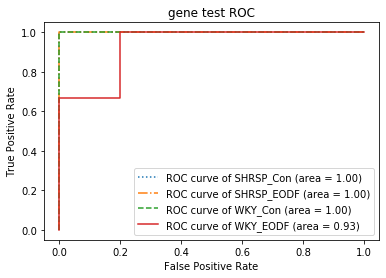

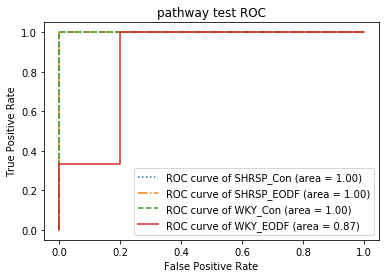

In [10]:
#ROC curves and AUC with testing data
#roc_curve only works with binary array, transform y_test to binary
label_binary = preprocessing.LabelBinarizer()
gene_test_binary=label_binary.fit_transform(gene_lb_test)
pathway_test_binary=label_binary.fit_transform(pathway_lb_test)
gene_prob = gene_classfier.predict_proba(gene_test)
pathway_prob = pathway_classfier.predict_proba(pathway_test)

#calculate true positive rate ans false positive rate 
gene_fpr = dict()
gene_tpr = dict()
gene_roc_auc = dict()

for i in range(4):
    gene_fpr[i], gene_tpr[i],_ = roc_curve(gene_test_binary[:,i],gene_prob[:,i])
    gene_roc_auc[i] = auc(gene_fpr[i],gene_tpr[i])

pathway_fpr = dict()
pathway_tpr = dict()
pathway_roc_auc = dict()
for i in range(4):
    pathway_fpr[i], pathway_tpr[i],_ = roc_curve(pathway_test_binary[:,i],pathway_prob[:,i])
    pathway_roc_auc[i] = auc(pathway_fpr[i],pathway_tpr[i])
    
#plot and save ROC curve    
gene_roc = plt.figure(0)
for i, ls in zip(range(4),[":","-.","--",'-']):
    plt.plot(gene_fpr[i],gene_tpr[i],linestyle = ls,label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(gene_lb.classes_[i], gene_roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("gene test ROC")


pathway_roc = plt.figure(2)
for i, ls in zip(range(4),[":","-.","--",'-']):
    plt.plot(pathway_fpr[i],pathway_tpr[i],linestyle = ls,label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(pathway_lb.classes_[i], pathway_roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("pathway test ROC")

gene_roc.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/gene_RF_test_roc.png",format="png")
pathway_roc.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/pathway_RF_test_roc.png",format="png")



In [96]:
gene_ecs

array(['1.1.1.100', '1.1.1.103', '1.1.1.125', ..., '6.5.1.1', '6.5.1.2',
       '6.5.1.4'], dtype=object)

In [99]:
#get feature importances from RF
gene_importance = pd.DataFrame(index=gene_ecs,columns=["Gene Name","importance"])
pathway_importance = pd.DataFrame(index=pathway_names,columns=["importance"])
gene_importance['Gene Name'] = gene_names
gene_importance['importance'] = gene_forest.feature_importances_
pathway_importance['importance'] = pathway_forest.feature_importances_
#save RF feature importances
gene_importance.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/gene_RF_feature_importances_accuracy_{0:0.0f}%.csv".format(gene_accuracies*100))
pathway_importance.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/pathway_RF_feature_importances_accuracy_{0:0.0f}%.csv".format(pathway_accuracies*100))



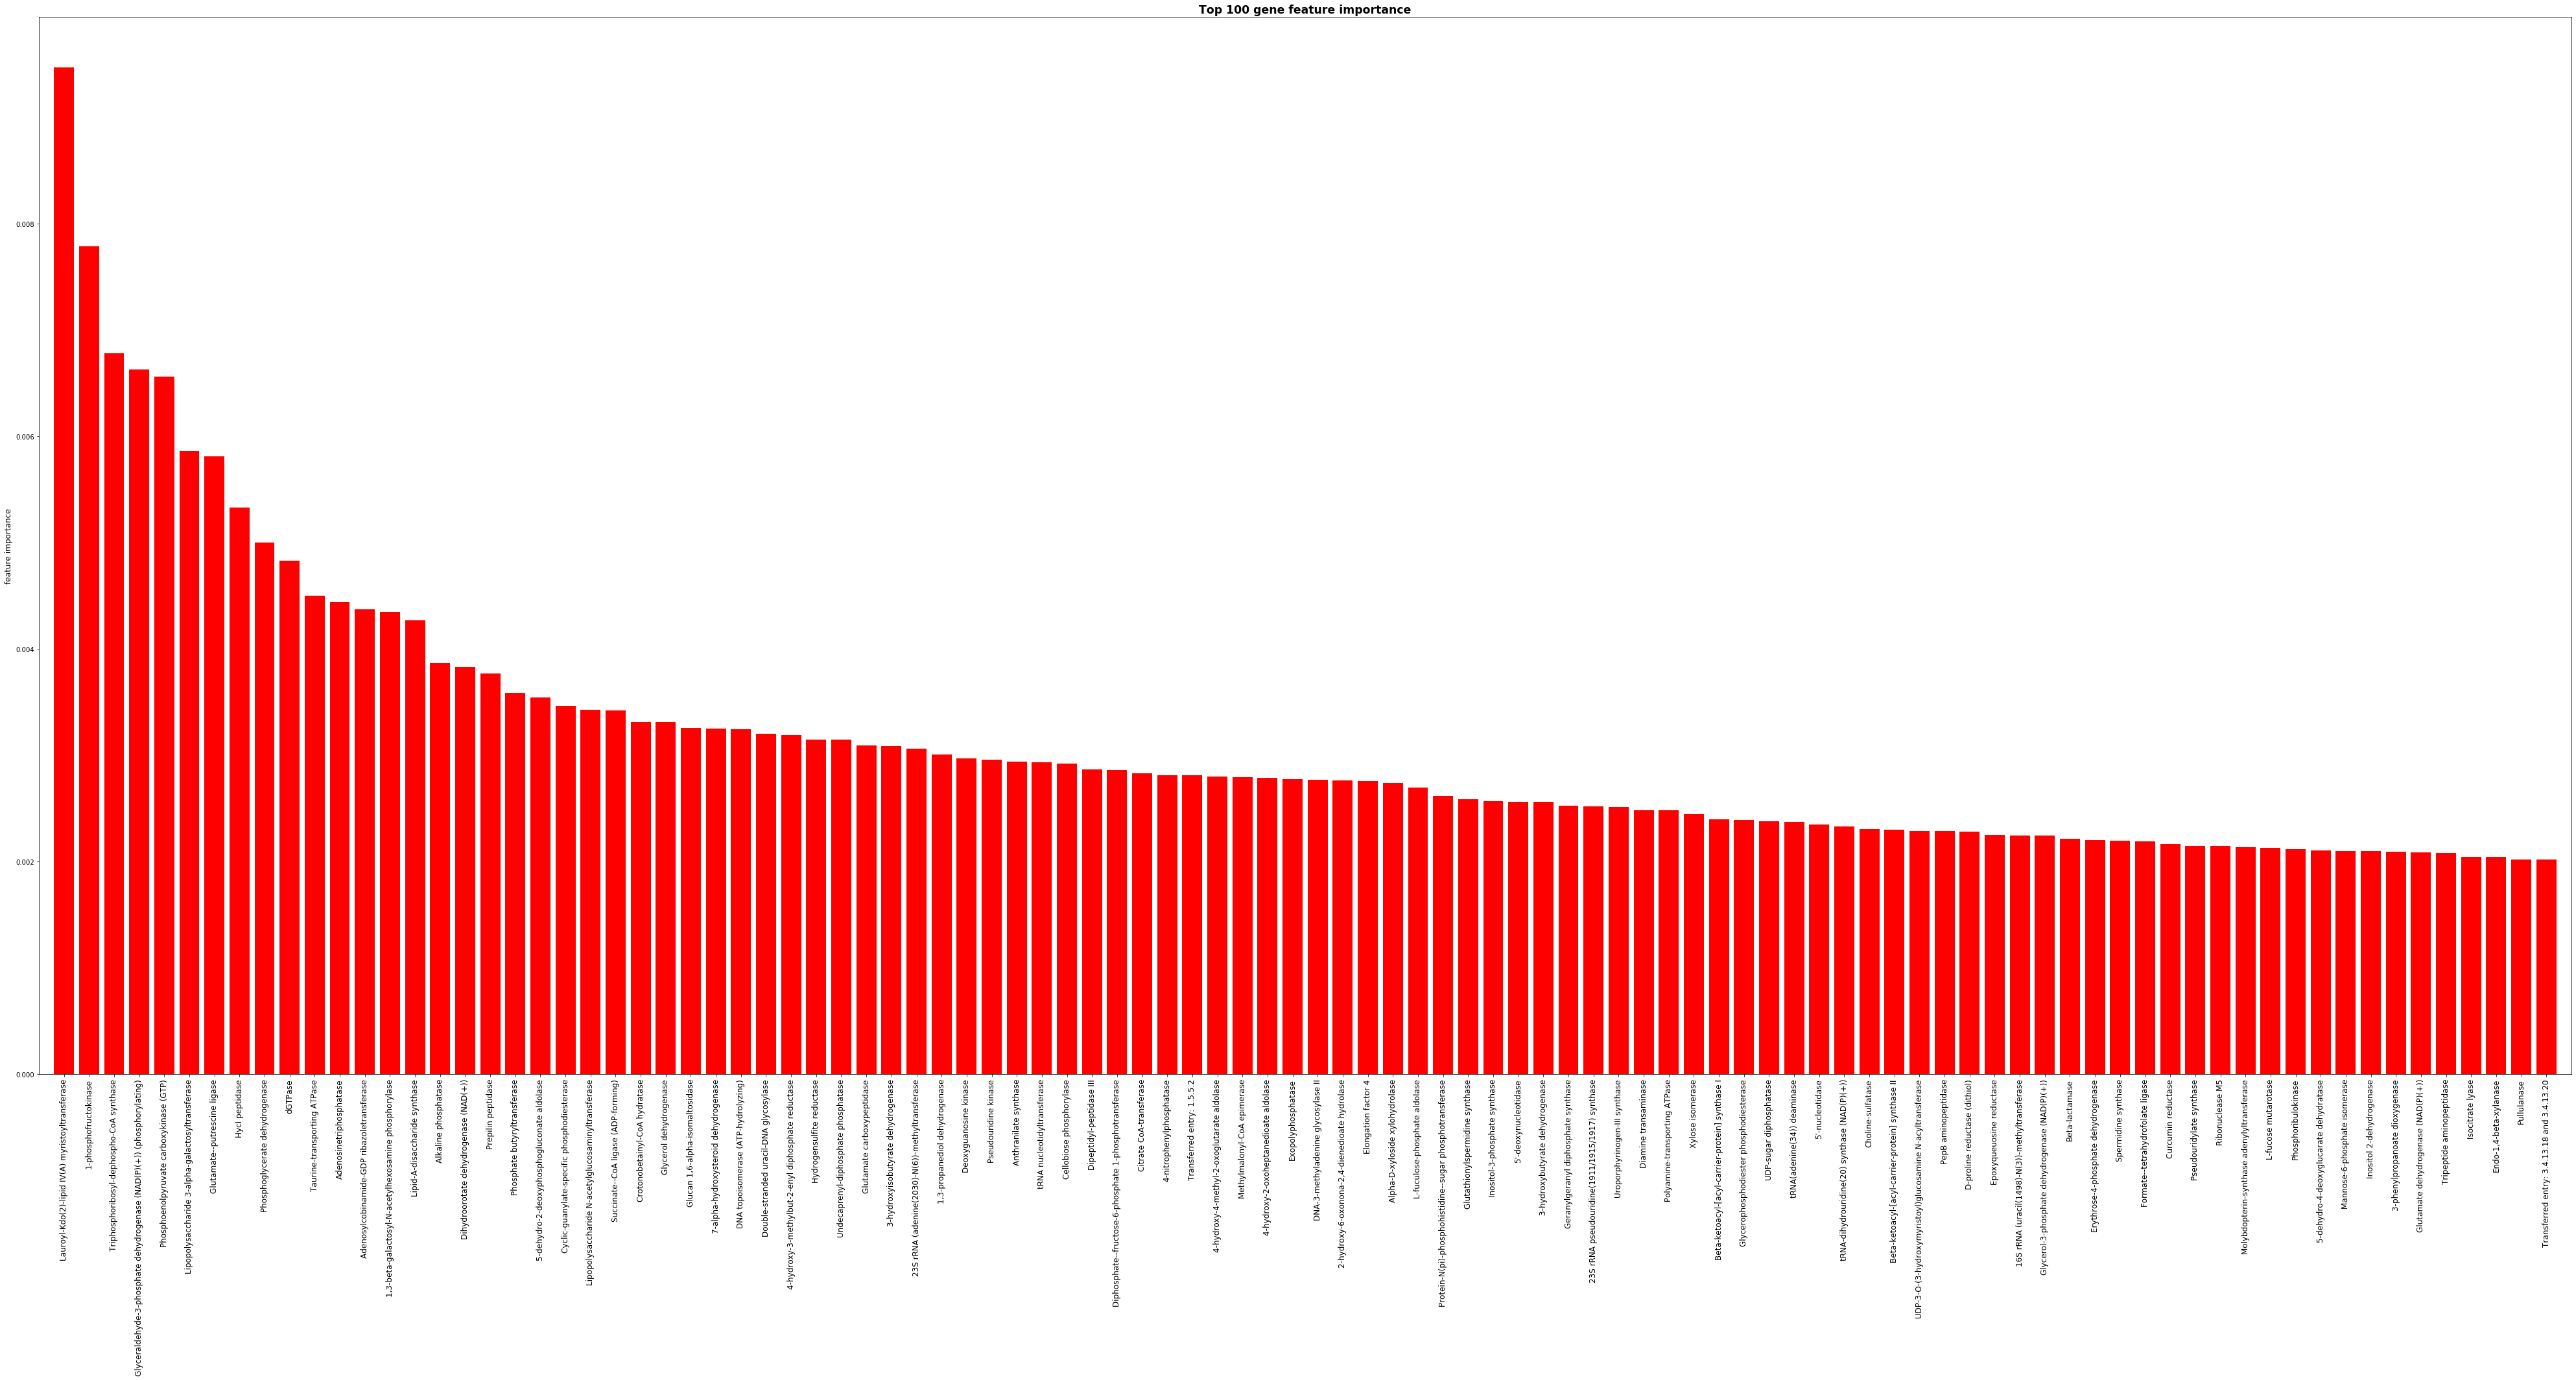

In [13]:
#Top 100 genes importances
importances = gene_classfier.feature_importances_
#std = np.std([tree.feature_importances_ for tree in gene_multi_target_forest.estimators_[0].estimators_],axis =0)
indices = np.argsort(importances)[::-1]
feature_list = [gene_names[indices[f]] for f in range(gene_names.shape[0])]
plt.figure()
plt.rcParams['figure.figsize'] = [70,30]
plt.title("Top 100 gene feature importance",fontsize="xx-large", fontweight = "bold")
plt.bar(range(100),importances[indices[0:100]],color = "r",align="center")
plt.xticks(range(100),np.array(feature_list)[indices[0:100]],rotation = 90,fontsize = "large")
plt.ylabel("feature importance",fontsize="large" )
plt.xlim([-1,100])
plt.show()


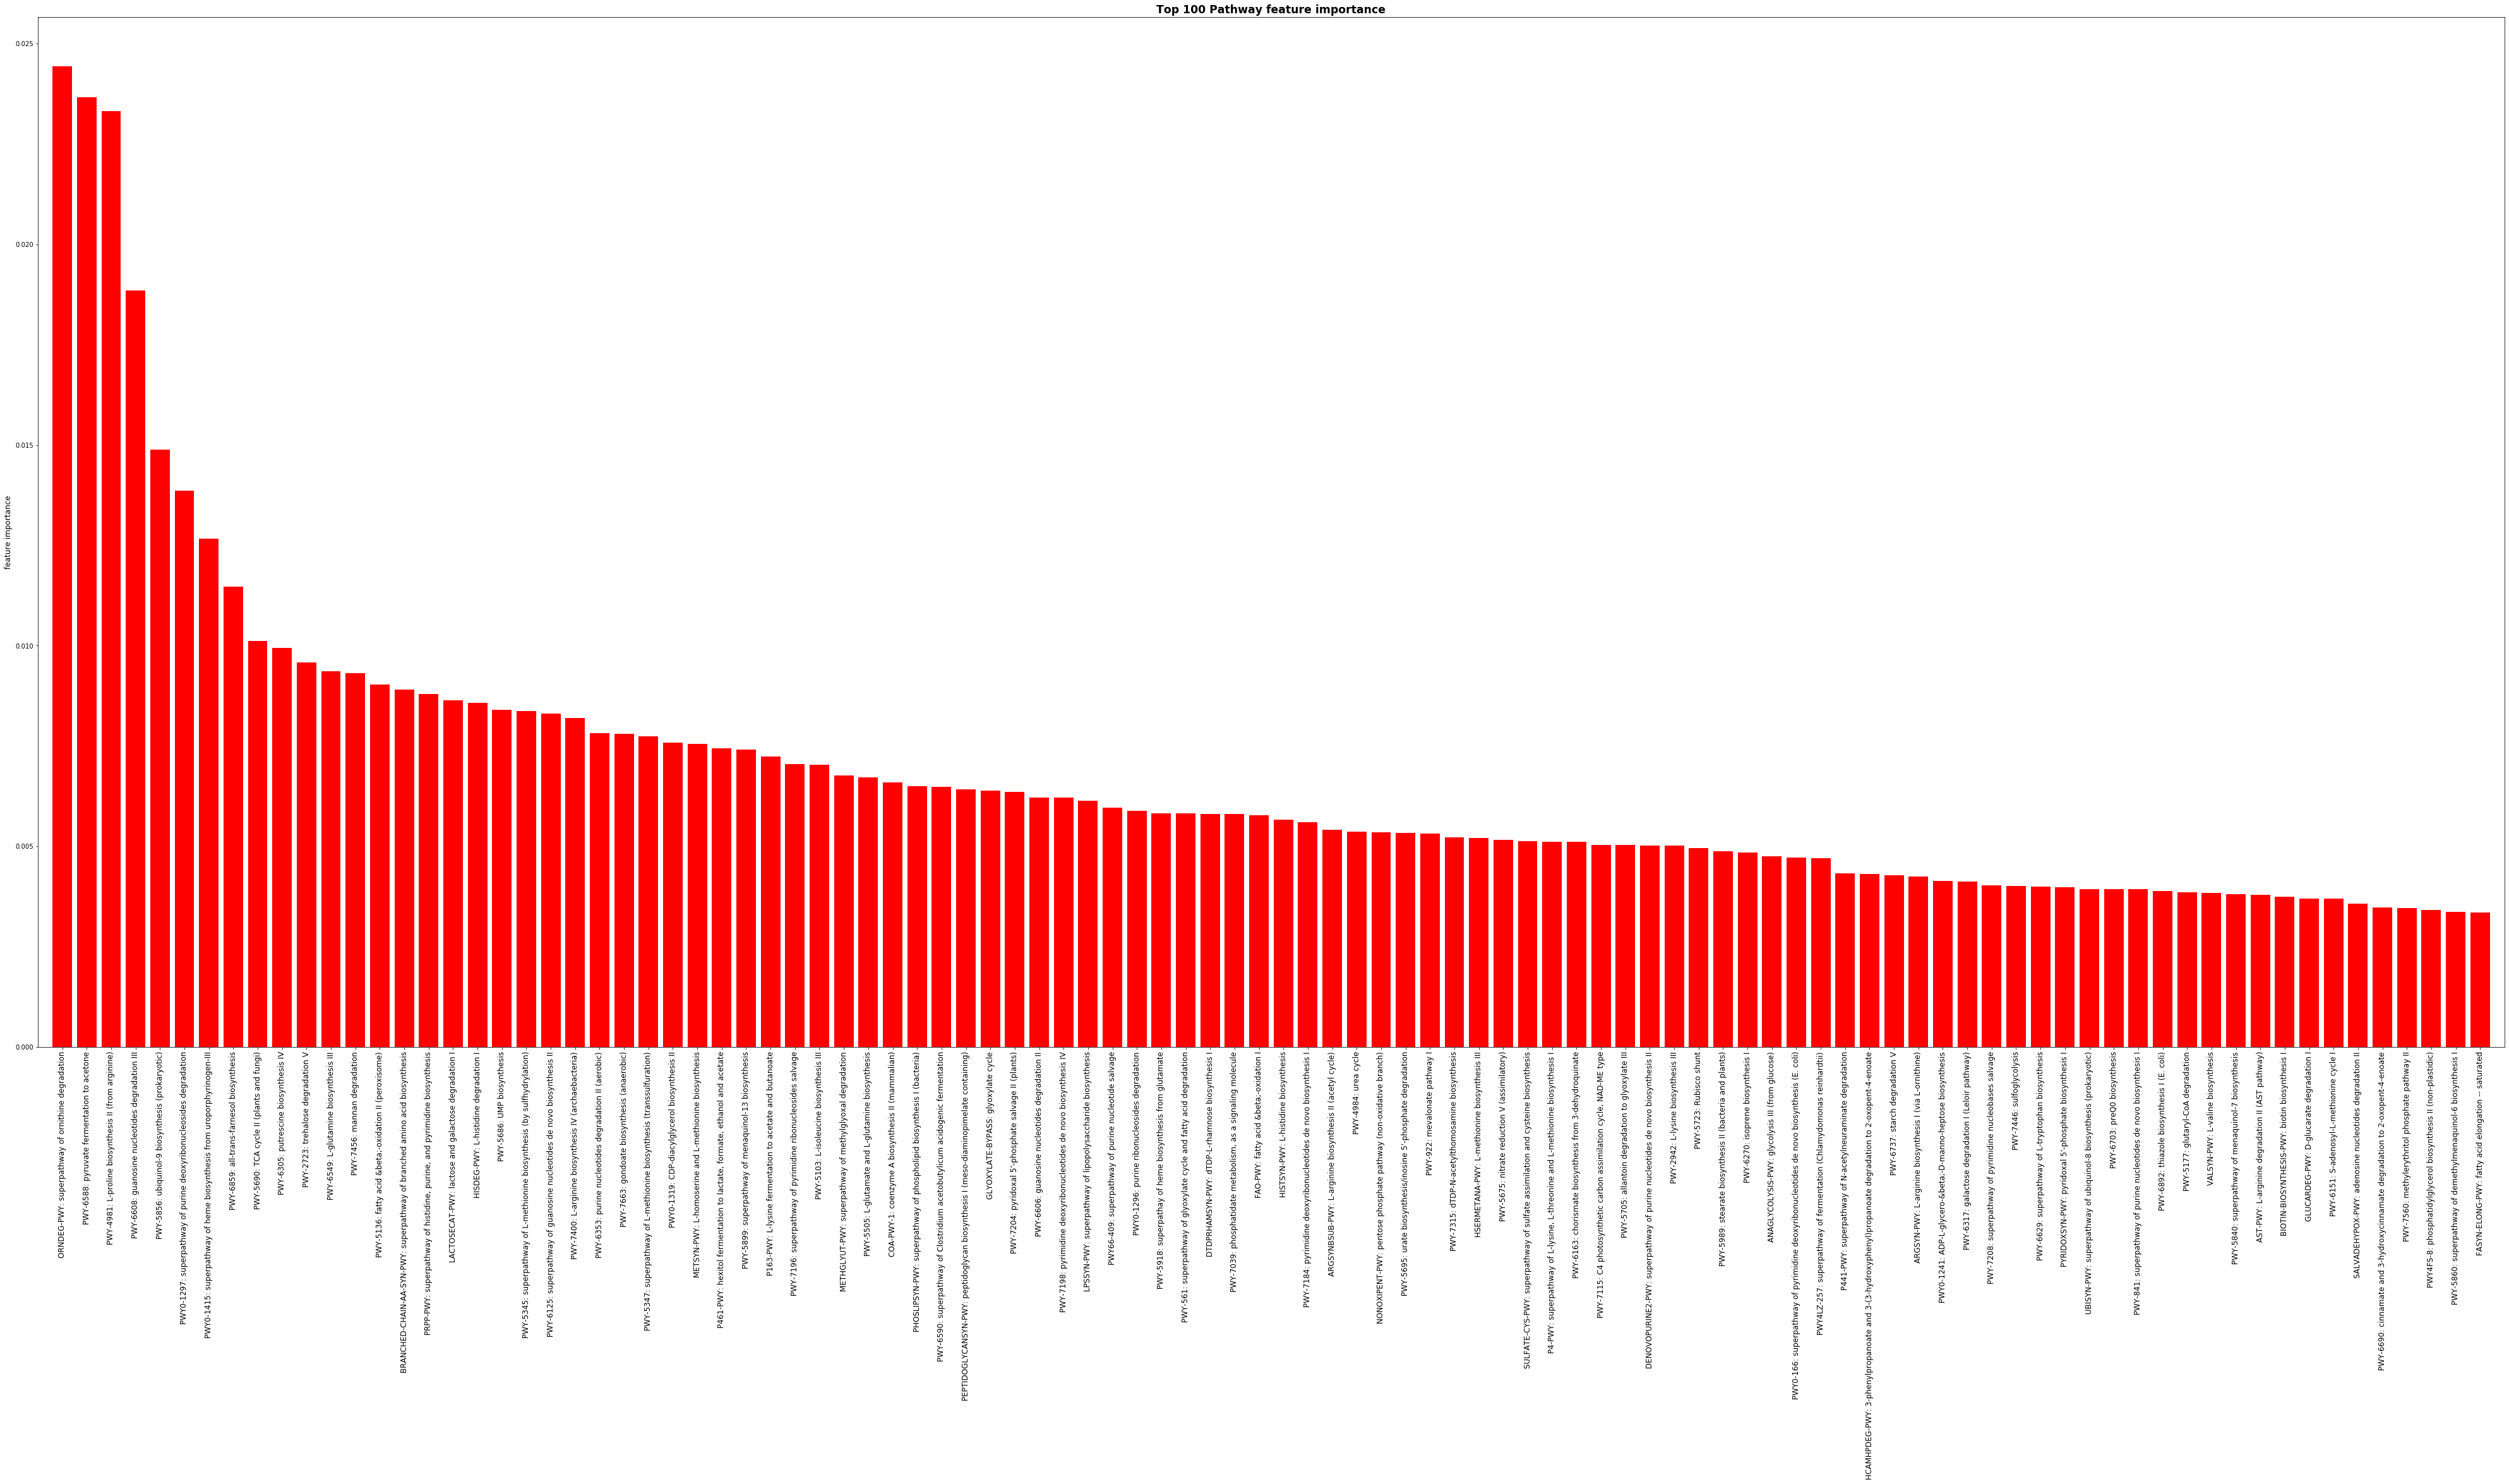

In [14]:
#Top 100 pathway importances 
importances = pathway_classfier.feature_importances_
std = np.std([tree.feature_importances_ for tree in pathway_classfier],axis =0)
indices = np.argsort(importances)[::-1]
feature_list = [pathway_names[indices[f]] for f in range(pathway_names.shape[0])]
plt.figure()
plt.rcParams['figure.figsize'] = [100,30]
plt.title("Top 100 Pathway feature importance",fontsize="xx-large", fontweight = "bold")
plt.bar(range(100),importances[indices[0:100]],color = "r",align="center")
plt.xticks(range(100),np.array(feature_list)[indices[0:100]],rotation = 90,fontsize = "large")
plt.ylabel("feature importance",fontsize="large" )
plt.xlim([-1,100])
plt.show()






In [100]:
#features that are significate different by anova and are all important 
gene_sig_index = gene_stats.index[gene_stats[gene_stats[["p_interaction","p_genotype","p_treatment"]]<=0.05].any(axis =1)].tolist()
pathway_sig_index = pathway_stats.index[pathway_stats[pathway_stats[["p_interaction","p_genotype","p_treatment"]]<=0.05].any(axis =1)].tolist()
gene_importance_sig = gene_importance.loc[gene_sig_index]
pathway_importance_sig = pathway_importance.loc[pathway_sig_index]
gene_importance_sig_nonzero = gene_importance_sig.loc[gene_importance_sig[gene_importance_sig["importance"]>0].any(axis =1).index]
pathway_importance_sig_nonzero = pathway_importance_sig.loc[pathway_importance_sig[pathway_importance_sig["importance"]>0].any(axis =1).index]
gene_importance_sig_nonzero = gene_importance_sig_nonzero.sort_values(by = ["importance"],ascending = False)
pathway_importance_sig_nonzero = pathway_importance_sig_nonzero.sort_values(by = ["importance"],ascending = False)
gene_importance_sig_nonzero.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/gene_RF_feature_importances_accuracy_{0:0.0f}%_sig_nonzero.csv".format(gene_accuracies*100))
pathway_importance_sig_nonzero.to_csv("/Users/huananshi/Box Sync/EODF_analysis/outputs/pathway_RF_feature_importances_accuracy_{0:0.0f}%_sig_nonzero.csv".format(pathway_accuracies*100))




<Figure size 5040x10800 with 0 Axes>

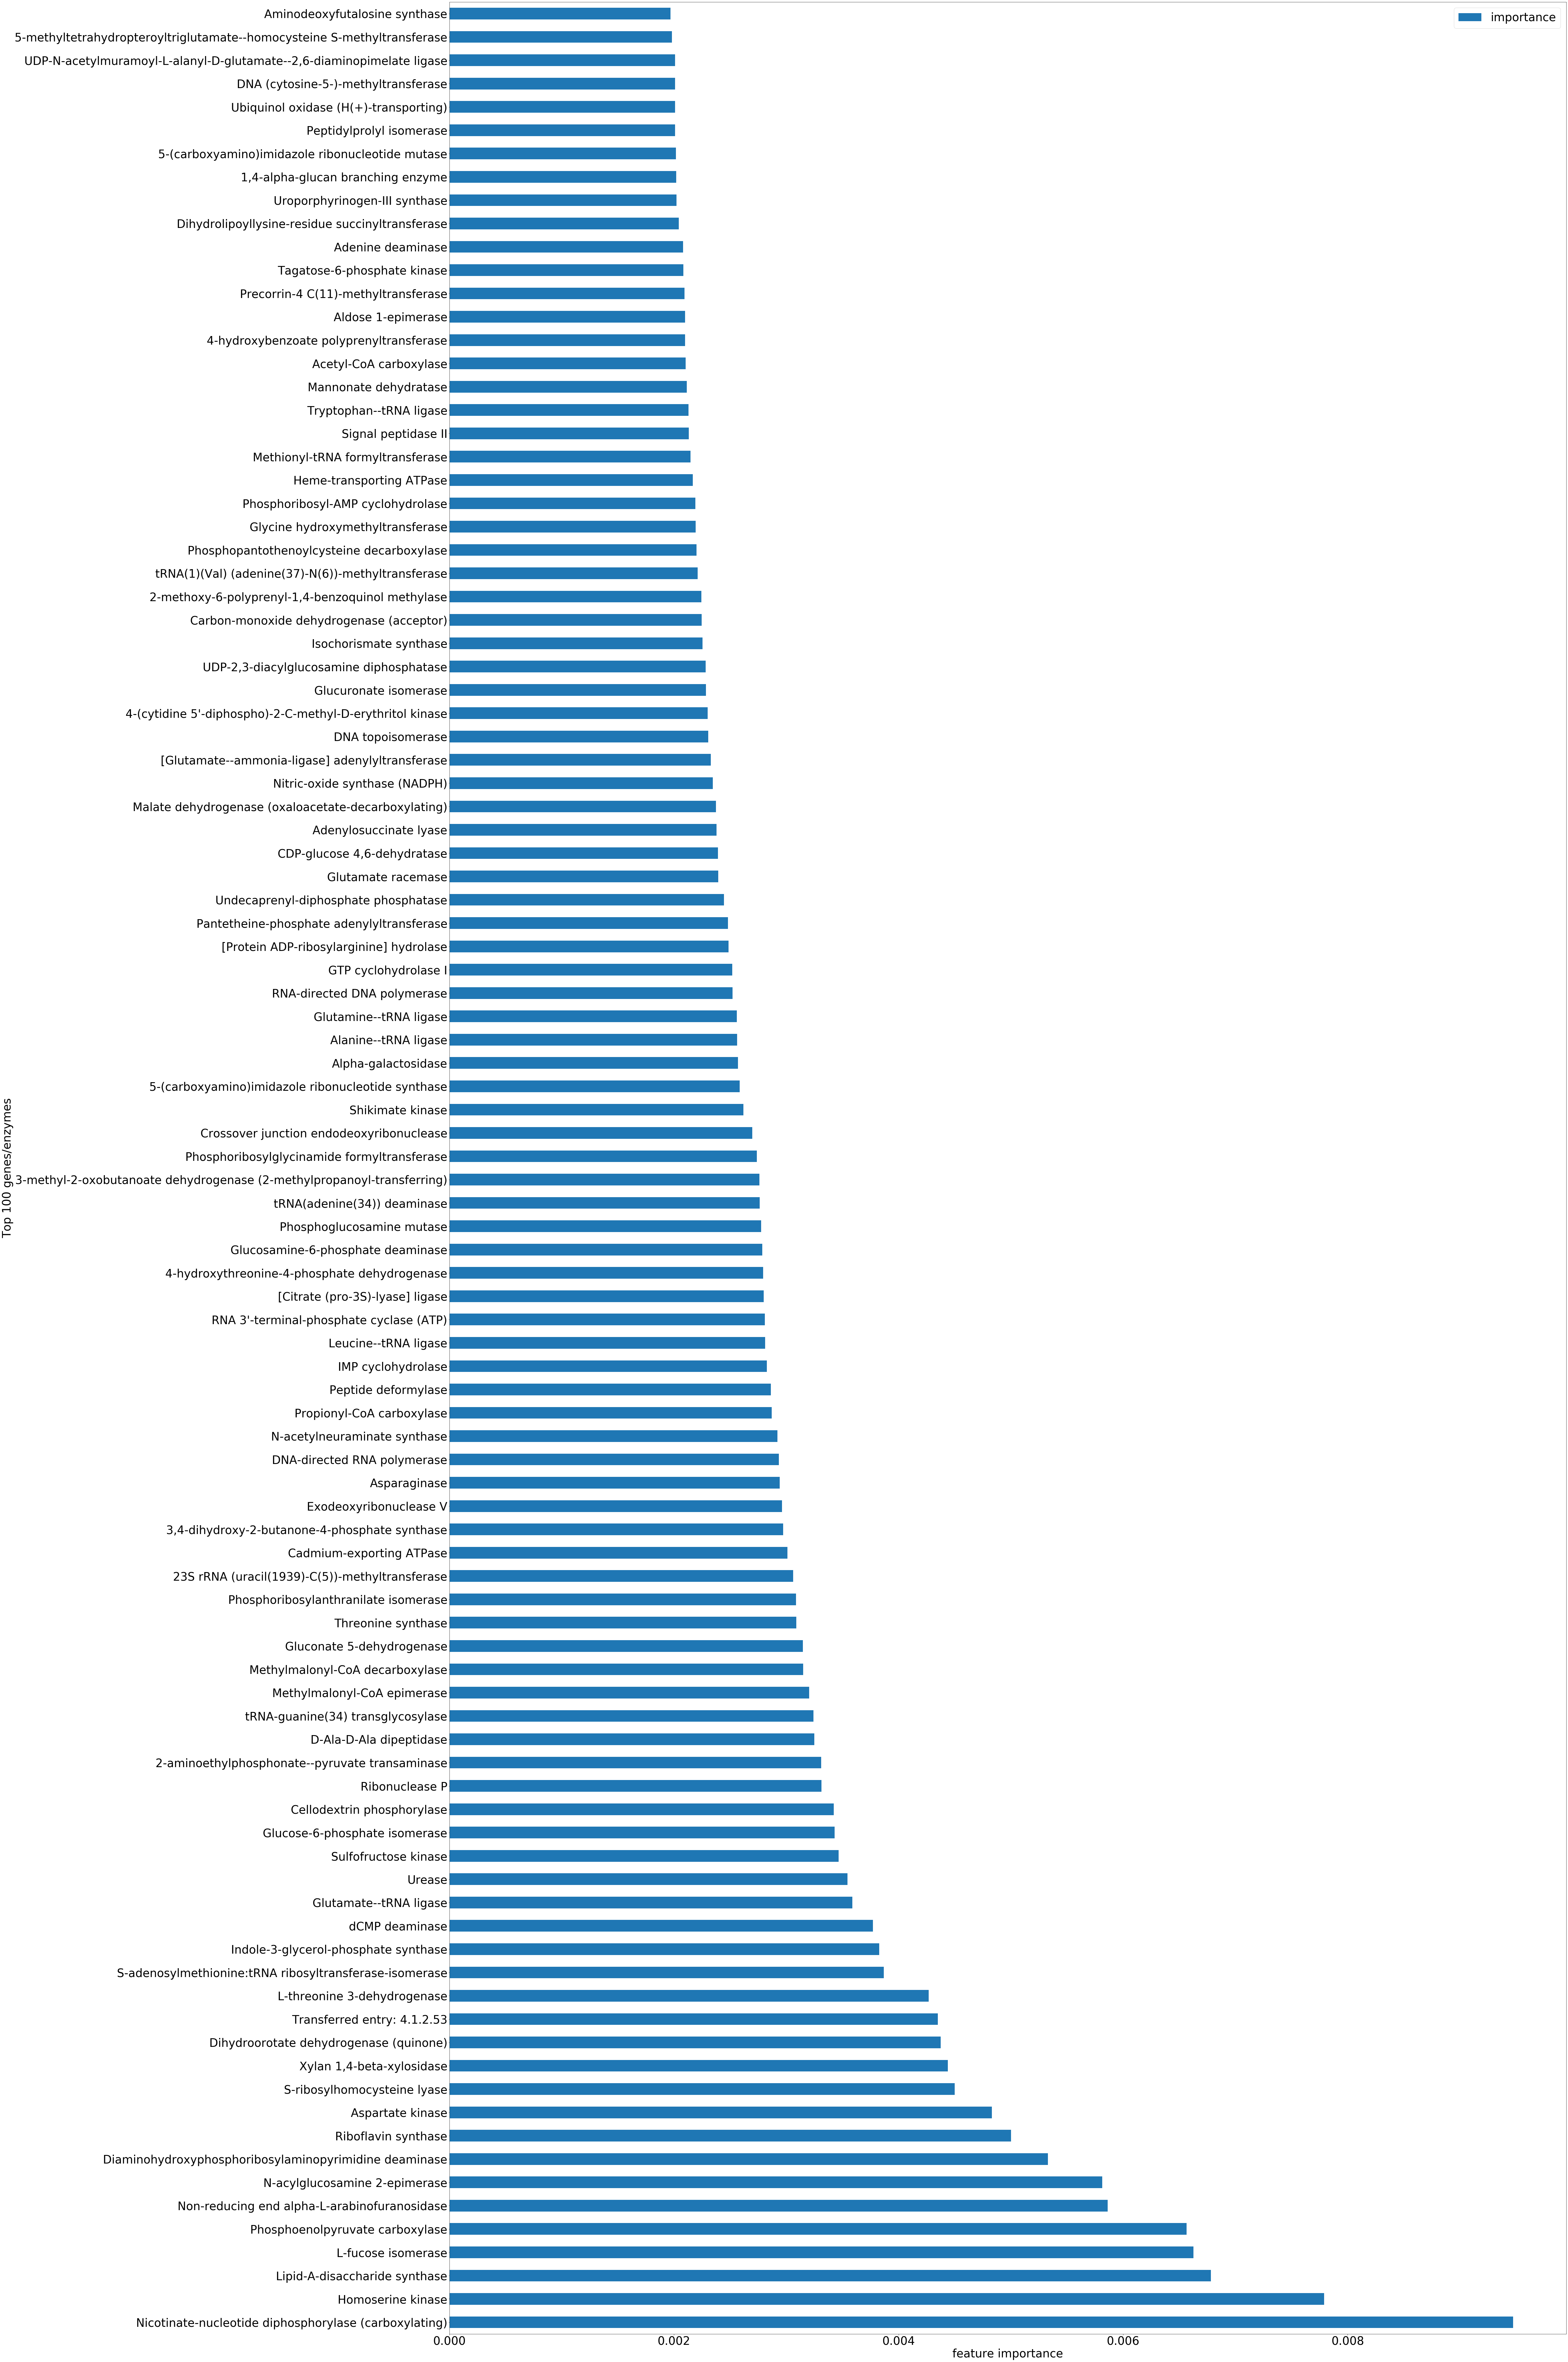

In [110]:
#plot gene importances (with significant features)
gene_fig = plt.figure(0)
plt.rcParams['figure.figsize'] = [70,150]
gene_ax = gene_importance_sig_nonzero.iloc[0:100].plot(y = gene_importance_sig_nonzero.columns[1], kind = "barh")
plt.yticks(range(100),gene_importance_sig_nonzero["Gene Name"][0:100],fontsize = 40)
plt.ylabel("Top 100 genes/enzymes", fontsize = 40)
plt.xticks(fontsize = 40)
plt.xlabel("feature importance",fontsize=40)
plt.legend(fontsize = 40)
gene_fig = gene_ax.get_figure()
gene_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/gene_RF_feature_importances_sig_nonzero_top100.svg", format= "svg")
                                                  

In [59]:
#plot pathway importances (with significant features)
pathway_fig = plt.figure(0)
plt.rcParams['figure.figsize'] = [70,150]
pathway_ax = pathway_importance_sig_nonzero.iloc[0:100].plot(y = pathway_importance_sig_nonzero.columns, kind = "barh")
plt.yticks(range(100),pathway_importance_sig_nonzero.index[0:100],fontsize = 40)
plt.ylabel("Top 100 pathways/enzymes", fontsize = 40)
plt.xticks(fontsize = 40)
plt.xlabel("feature importance",fontsize=40)
plt.legend(fontsize = 40)
pathway_fig = pathway_ax.get_figure()
pathway_fig.savefig("/Users/huananshi/Box Sync/EODF_analysis/outputs/pathway_RF_feature_importances_sig_nonzero_top100.svg", format= "svg")
                                                  

<Figure size 5040x10800 with 0 Axes>

In [63]:
#calculate feature importance by classes
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = preprocessing.scale(X)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

In [69]:
#calculate feature importance by classes
gene_importance_by_class = class_feature_importance(gene_reads, gene_labels, gene_classfier.feature_importances_)
pathway_importance_by_class = class_feature_importance(pathway_reads, pathway_labels, pathway_classfier.feature_importances_)
gene_importance_by_class = pd.DataFrame(gene_importance_by_class)
gene_importance_by_class.index = gene_names
pathway_importance_by_class = pd.DataFrame(pathway_importance_by_class)
pathway_importance_by_class.index = pathway_names
gene_importance_by_class.to_csv(
    "/Users/huananshi/Box Sync/EODF_analysis/outputs/gene_RF_feature_importances_by_class_accuracy_{0:0.0f}%.csv"
    .format(gene_accuracies*100))

pathway_importance_by_class.to_csv(
    "/Users/huananshi/Box Sync/EODF_analysis/outputs/pathway_RF_feature_importances_by_class_accuracy_{0:0.0f}%.csv"
    .format(pathway_accuracies*100))



[Text(2170.0, 7134.75, 'X[526] <= 0.167\ngini = 0.71\nsamples = 12\nvalue = [5, 4, 2, 7]\nclass = WKY_EODF'),
 Text(1302.0, 5096.25, 'X[457] <= -0.594\ngini = 0.58\nsamples = 6\nvalue = [5, 4, 1, 0]\nclass = SHRSP_Con'),
 Text(868.0, 3057.75, 'X[982] <= 0.135\ngini = 0.32\nsamples = 3\nvalue = [0, 4, 1, 0]\nclass = SHRSP_EODF'),
 Text(434.0, 1019.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 4, 0, 0]\nclass = SHRSP_EODF'),
 Text(1302.0, 1019.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0]\nclass = WKY_Con'),
 Text(1736.0, 3057.75, 'gini = 0.0\nsamples = 3\nvalue = [5, 0, 0, 0]\nclass = SHRSP_Con'),
 Text(3038.0, 5096.25, 'X[1229] <= 1.649\ngini = 0.219\nsamples = 6\nvalue = [0, 0, 1, 7]\nclass = WKY_EODF'),
 Text(2604.0, 3057.75, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 0, 7]\nclass = WKY_EODF'),
 Text(3472.0, 3057.75, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0]\nclass = WKY_Con')]

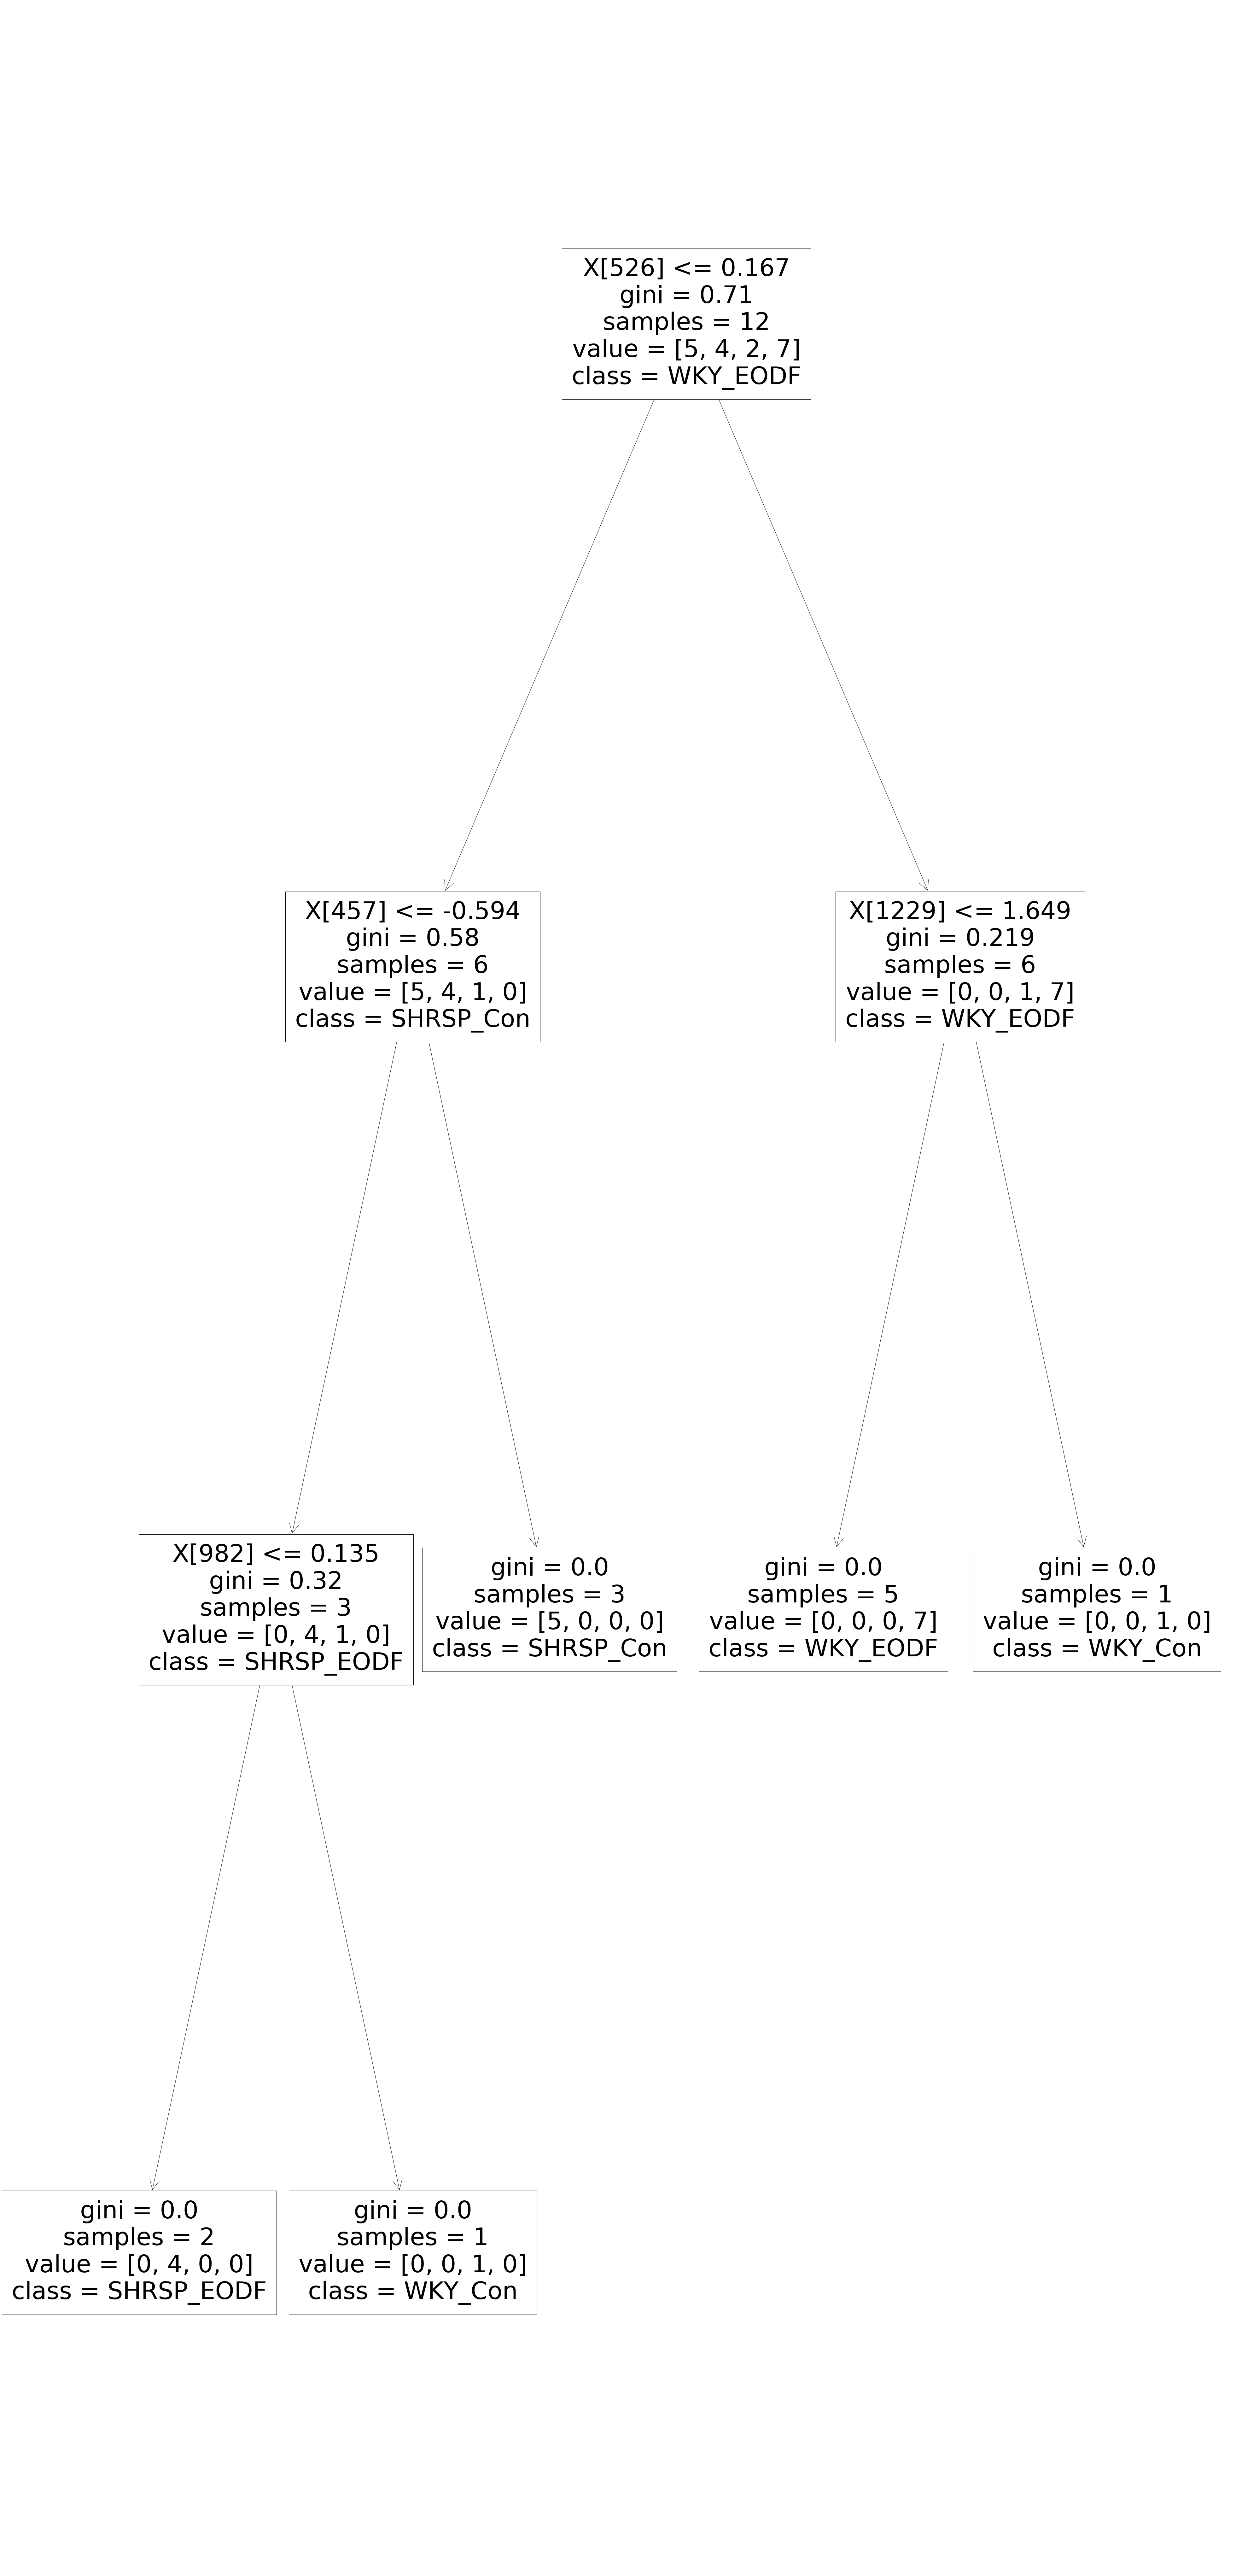

In [81]:
#example of plot tree

plot_tree(gene_classfier.estimators_[0], class_names=gene_lb.classes_)



[Text(1953.0, 7134.75, 'X[188] <= 0.106\ngini = 0.71\nsamples = 12\nvalue = [5, 4, 2, 7]\nclass = WKY_EODF'),
 Text(976.5, 5096.25, 'X[142] <= -0.636\ngini = 0.58\nsamples = 6\nvalue = [5, 4, 0, 1]\nclass = SHRSP_Con'),
 Text(488.25, 3057.75, 'gini = 0.0\nsamples = 3\nvalue = [5, 0, 0, 0]\nclass = SHRSP_Con'),
 Text(1464.75, 3057.75, 'X[21] <= 0.141\ngini = 0.32\nsamples = 3\nvalue = [0, 4, 0, 1]\nclass = SHRSP_EODF'),
 Text(976.5, 1019.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 4, 0, 0]\nclass = SHRSP_EODF'),
 Text(1953.0, 1019.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1]\nclass = WKY_EODF'),
 Text(2929.5, 5096.25, 'X[303] <= 0.698\ngini = 0.375\nsamples = 6\nvalue = [0, 0, 2, 6]\nclass = WKY_EODF'),
 Text(2441.25, 3057.75, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 0, 6]\nclass = WKY_EODF'),
 Text(3417.75, 3057.75, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2, 0]\nclass = WKY_Con')]

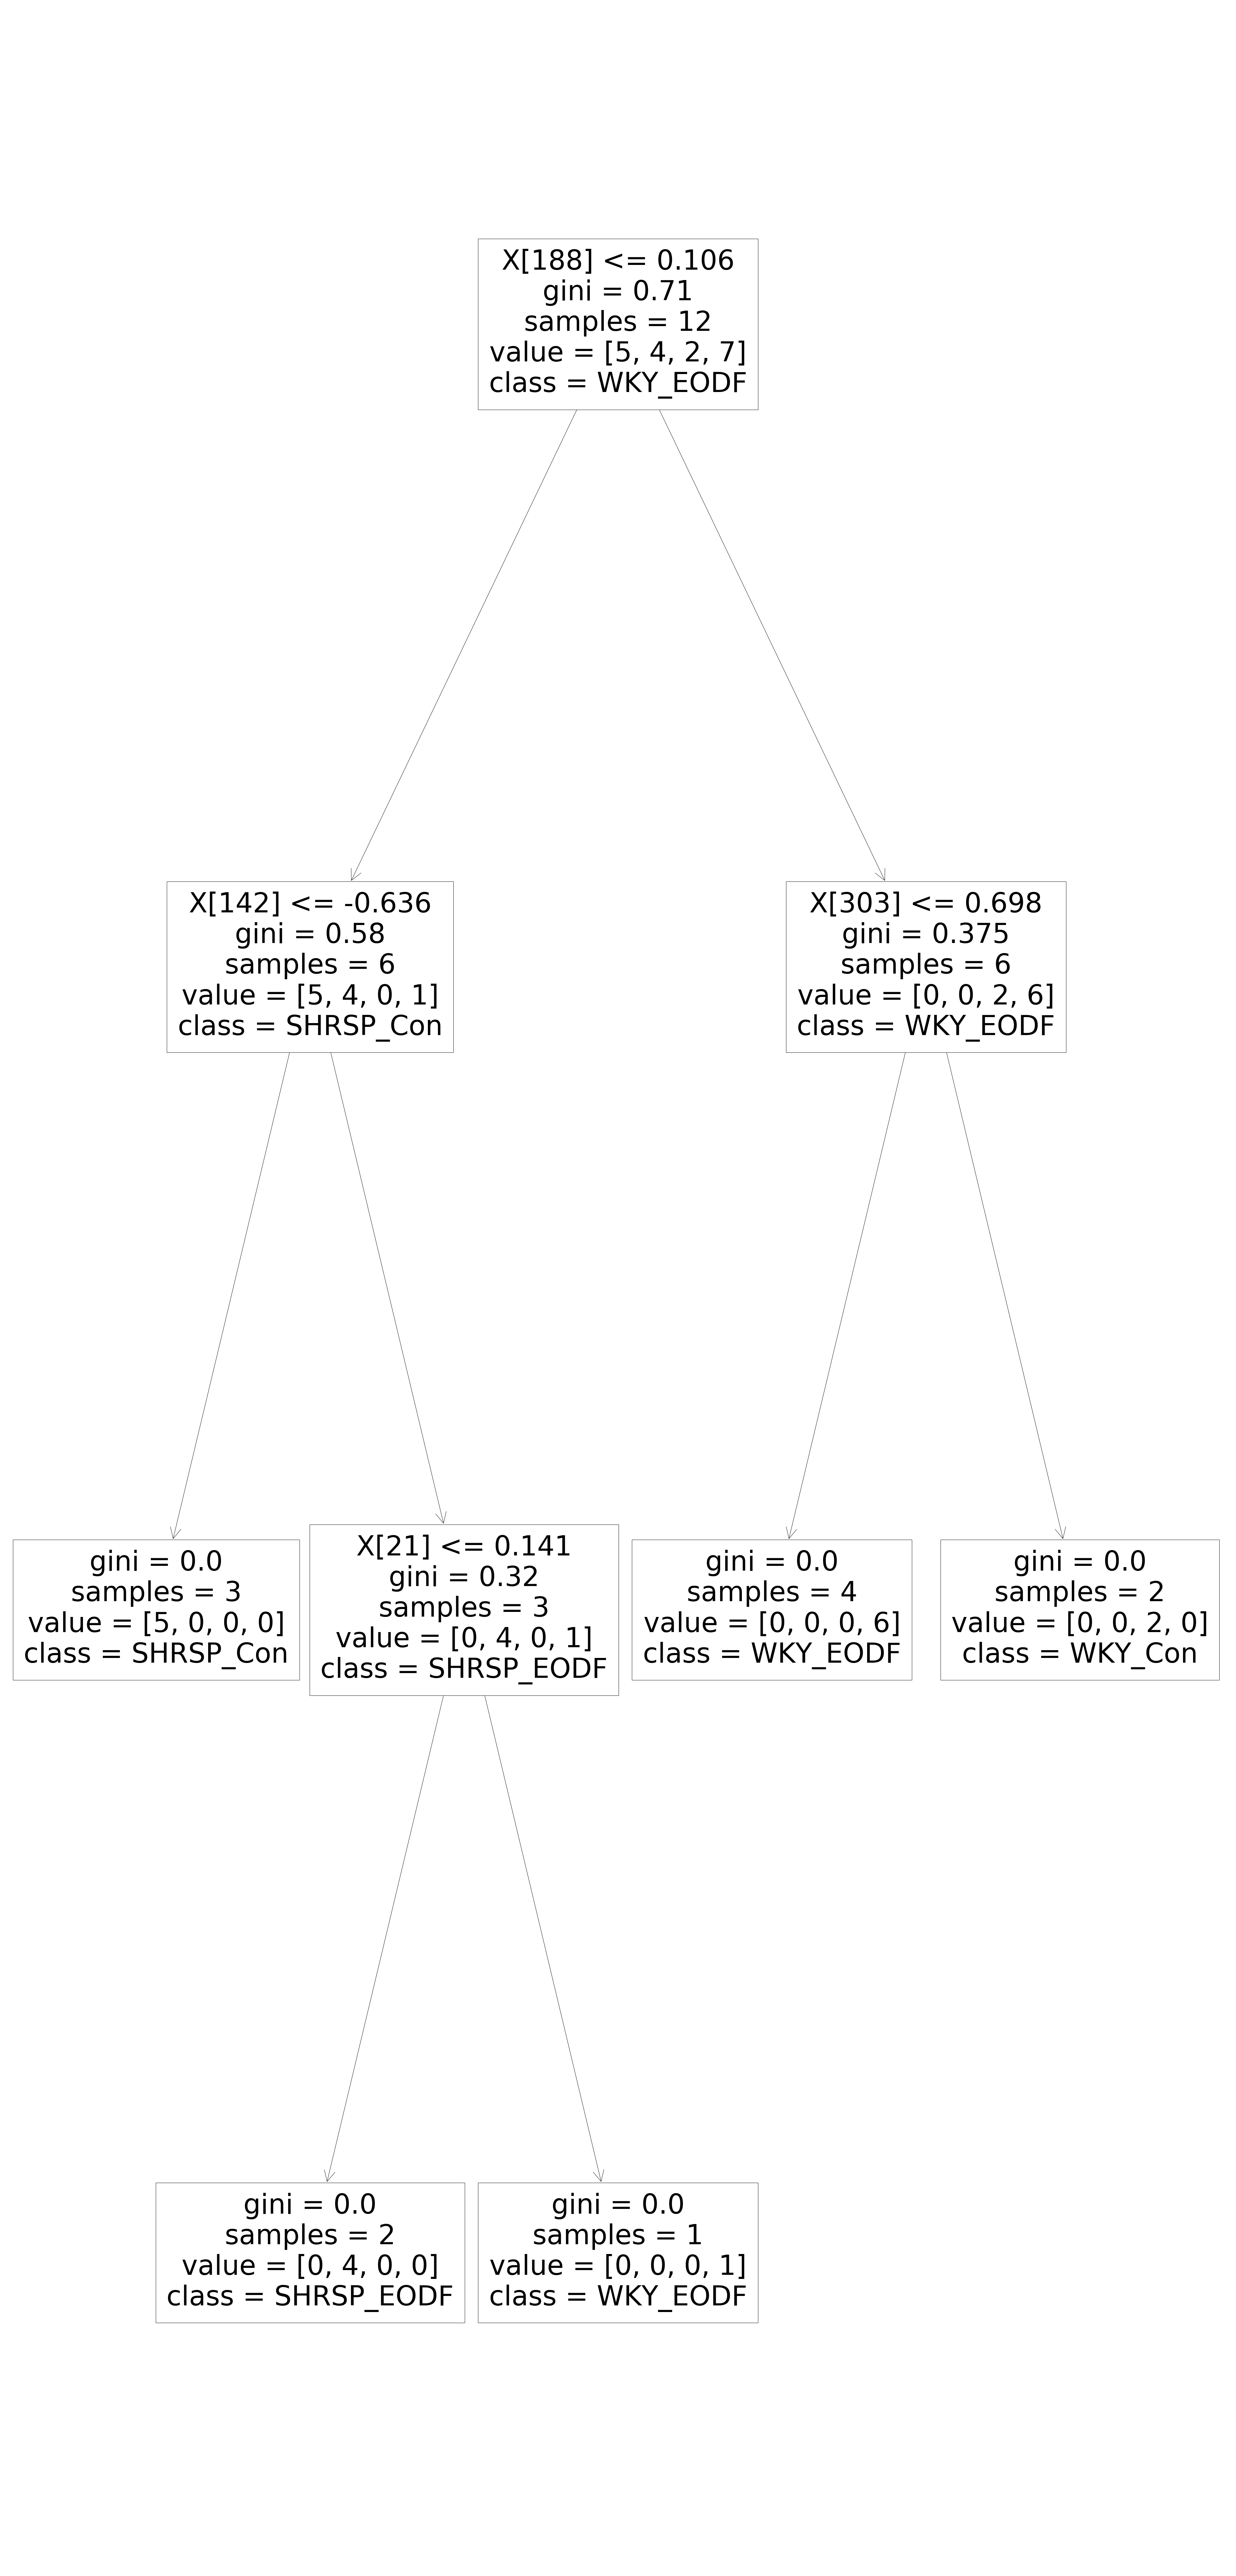

In [86]:
plot_tree(pathway_classfier.estimators_[0], class_names=pathway_lb.classes_)

